In [1]:
# Default libraries, packages for data management, visualization and Computer vision libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sklearn package -> function
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tensorflow packages
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121

2024-11-24 13:22:12.138628: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732425732.271961    2769 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732425732.308857    2769 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-24 13:22:12.648155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
def directory_to_df(path : str):
    """
    This function to retrieve all images from targeted folder in a file, the
    folder must be divided hirarchally in which each class contains its images individually.
    ________________________________________________________________________________________________
    Arguments-
    
    path: String -> the main folder directory that contains train/test folders
    
    ________________________________________________________________________________________________
    Return-
    
    DataFrame: contains the images path and label corresponding to every image
    """
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz'    # to include lowercase letters only
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    """
    Read an image from specified directory
    _____________________________________________________________
    Arguments:
    
    path: String -> a directory of the image
    _____________________________________________________________
    Return:
    
    image: numpy.array of the image
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
    """
    This function to display any image
    _________________________________________________________
    Arguements:
    
    img: numpy.array of N-D
    
    label: String -> the title/label added with the image, Default= None
    _________________________________________________________
    Return:
    
    plt.imshow()
    """
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    # The function is defined to make the callbacks for training the models
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras',verbose=1, save_best_only=True)
    return [ERLY,RD,CHK]

In [3]:
# Pre-defined hyperparameters
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

I0000 00:00:1732425823.832967    2769 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4056 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:
# Reading the dataset in dataframe 
main_path = 'data/raw/character_set3/'
df = directory_to_df(main_path)                   # convert the dataset into df of two columns
df.head()

The number of samples found: 85199


,image,label
0,data/raw/character_set3/v/V_L_1680.png,v
1,data/raw/character_set3/v/V_L_3025.png,v
2,data/raw/character_set3/v/V_L_682.png,v
3,data/raw/character_set3/v/V_L_1476.png,v
4,data/raw/character_set3/v/V_L_571.png,v


In [5]:
df['label'].value_counts()

label
e    3284
r    3284
n    3281
a    3281
m    3281
q    3279
u    3278
i    3277
d    3277
s    3276
x    3276
l    3276
k    3276
y    3276
t    3276
g    3275
p    3275
o    3275
f    3275
h    3275
w    3275
z    3275
v    3274
c    3274
b    3274
j    3274
Name: count, dtype: int64

In [6]:
# Splitting for training & testing (70,30 respectively)
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [7]:
# Splitting for training & validation (75,25 respectively) -> the training set size = 52.5%
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

In [8]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 44729 validated image filenames belonging to 26 classes.
Found 14910 validated image filenames belonging to 26 classes.
Found 25560 validated image filenames belonging to 26 classes.


In [9]:
# Making a mapping of the classes and the inverse for later processings
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

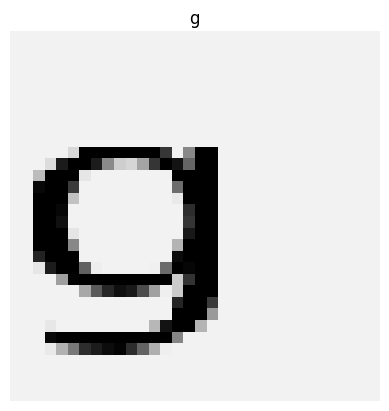

The shape of the image: (32, 32, 3)


In [10]:
# Reading a sample from the dataset
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

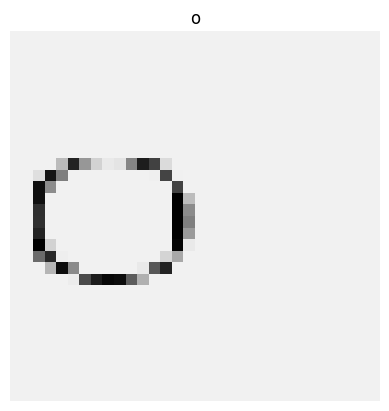

The shape of the image: (32, 32, 3)


In [11]:
# Reading another sample from the dataset
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

In [12]:
# Custom CNN
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [13]:
CNN_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 32, 32, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 30, 30, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 10, 10, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 8, 8, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 2, 2, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 2, 2, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 2, 2, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 1, 1, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 26)               │        26,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,243,502 (20.00 MB)

 Trainable params: 5,243,502 (20.00 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Default parameters of adam will be used for the custom CNN
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [18]:
# different num. of epochs will be given for better convergence for the Custom CNN
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20


E0000 00:00:1732426484.200883    3161 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1732426484.280009    3161 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2024-11-24 13:34:44.287004: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at xla_ops.cc:577 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 641, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1987, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_2769/747295854.py", line 2, in <module>

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/dangazelle/.venv/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_3168]